
Loading + preprocessing data refs:
1. https://www.kaggle.com/code/leifuer/intro-to-pytorch-loading-image-data
2. https://www.kaggle.com/code/creativesquad/alexnet-batch-size
3. https://www.kaggle.com/code/quangtheng/pytorch-cnn-brain-tumor-accuracy-95-76

Model + training refs:

1. https://cognitiveclass.ai/courses/vision-transformers-for-image-classification-hands-on

Reads
1. https://stackoverflow.com/questions/55894132/how-to-correct-unstable-loss-and-accuracy-during-training-binary-classificatiohttps://stackoverflow.com/questions/55894132/how-to-correct-unstable-loss-and-accuracy-during-training-binary-classificatio

In [29]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [30]:
import os
from typing import Union

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import pandas as pd
from PIL import Image
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from tqdm import tqdm

import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR

In [31]:
def plot_samples(dataset,  classes:Union[None, dict], size_even=6):
    
    size_even = 6  # Default number of samples to plot
    fig, axs = plt.subplots(2, int(size_even // 2))  # Create subplots for the samples

    if classes is None:
        classes = tuple([n for n in range(len(dataset))])  # Default class labels

    n_samples = len(dataset)  # Total number of samples in the dataset

    # Randomly select samples
    samples = np.random.randint(0, high=n_samples - 1, size=int(size_even))

    row = 0
    col = 0
    for n, sample in enumerate(samples):
        img = dataset[sample][0]  # Get the image from the dataset
        label = "y={}".format(classes[int(dataset[sample][1])])  # Get the label for the image

        col = n

        # Determine the row and column index for the current sample
        if n > size_even / 2 - 1:
            row = 1
            col = n - int(size_even / 2)

        # Display the image and label in the corresponding subplot
        axs[row, col].imshow(make_grid(img, normalize=True).permute(1, 2, 0))
        axs[row, col].set_title(label)
        axs[row, col].axis('off')

In [32]:
def plot_image_patchs(patchs, seq=False):

    if patchs.shape[-3] == 1:
        patchs = patchs.repeat(1, 1, 3, 1, 1)  # Add 3 channel dimension if image is grayscale

    N_patchs = patchs.shape[1]  # Number of image patches

    plot_patchs = make_grid(patchs, normalize=True).permute(0, 2, 3, 1)  # Arrange patches for plotting

    N_rows = int(np.sqrt(N_patchs))  # Number of rows for the grid plot

    # Create subplots for the image patches
    if seq:
        fig, ax = plt.subplots(1, N_rows * N_rows, sharex='col', sharey='row', figsize=(25, 5))
        fig.suptitle("Image as Sequence")
    else:
        fig, ax = plt.subplots(N_rows, N_rows, sharex='col', sharey='row')
        fig.suptitle("Image")

    i, j = 0, 0
    for n in range(N_patchs):
        if seq:
            ax[n].imshow(plot_patchs[n])
            ax[n].set_xlabel(str(n + 1))
            ax[n].axes.xaxis.set_ticklabels([])
            ax[n].axes.yaxis.set_ticklabels([])
        else:
            if n % N_rows == 0 and n != 0:
                i += 1
                j = 0

            ax[i, j].imshow(plot_patchs[n])
            ax[i, j].set_ylabel(str(n + 1))
            ax[i, j].axes.xaxis.set_ticklabels([])
            ax[i, j].axes.yaxis.set_ticklabels([])
            j += 1

    plt.show()


In [33]:
def plot_patchs_lables(X, y, label=True, p_show=0.5):
    '''
    The code implements a function for plotting t-SNE visualization of patches and their labels, with the option to label each point and control
    the frequency of labeling for the sequence index.

    X: This is a tensor representing the data to be plotted. It should have the shape (sample, patch, dim), where sample is the number of samples, patch is the size of each patch or sequence length, and dim is the number of features for each patch.
    y: This is a tensor representing the labels for each sample. It should have the shape (sample, 1).
    label: This is a boolean value that controls whether to label each data point in the plot. If label is set to True, each data point in the plot will be labeled.
    p_show: This is a float value between 0 and 1 that controls the frequency of labeling for the sequence index. It specifies the probability of showing a label for each data point. For example, if p_show is set to 0.5, then approximately half of the data points will be labeled.
    '''

    # Detach X from its computational graph if it's not a leaf node
    if not (X.is_leaf):
        X = X.detach()

    # Get the shape of the input tensor X
    if X.shape[0] == 49:
        sample = X.shape[1]
        patch = X.shape[0]  # Patch size or sequence length
        dim = X.shape[2]
    if X.shape[0] == 1000:
        sample = X.shape[0]
        patch = X.shape[1]
        dim = X.shape[2]

    # Reshape X and convert it to a numpy array
    X = X.reshape(sample * patch, dim).numpy()

    # Flatten the y tensor and convert it to a numpy array to label each sequence
    colors = y.repeat(patch, 1).T.flatten().numpy()

    # Perform t-SNE on the X data
    X_ = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)

    # Create a scatter plot of the t-SNE transformed X data with each class labeled via color
    fig, ax = plt.subplots()
    for color in np.unique(colors):
        temp = colors == color
        ax.scatter(X_[temp, 0], X_[temp, 1], label=color)

    # If the label argument is set to True, add labels to the scatter plot
    if label:
        for i, x in enumerate(X_):
            # Label plots with a probability of p_show
            if np.random.binomial(1, p_show, 1).item() == 1:
                ax.annotate(str(i % patch), (x[0], x[1]))

    # Add a legend to the scatter plot
    ax.legend()

In [34]:
def img_to_patch(x, patch_size, flatten_channels=True, show_prints=False):
    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    if show_prints: print('img_to_patch() | reshaped', x.shape)

    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    if show_prints: print('img_to_patch() | permute', x.shape)
    
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    if show_prints: print('img_to_patch() | flatten', x.shape)
    
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
        # Returns [batch, channel, (height//patchsize * patchsize * width//patchsize * patchsize)]
        # ie lump all of current sample into the 3rd axis = [batch, channel, all pixels from the current sample]
        if show_prints: print('img_to_patch() | flatten_channels', x.shape)
    return x

In [35]:
data_dir = '/kaggle/input/brain-tumor'

# Inisiasi dataframe kosong
df = pd.DataFrame(columns=["image", "label"])

# Tambah data ke dataframe
def add_data_to_df(path, label_map):
    for label in os.listdir(path):
        label_path = os.path.join(path, label)
        if os.path.isdir(label_path):
            for image in os.listdir(label_path):
                image_path = os.path.join(label_path, image)
                df.loc[len(df)] = [image_path, label_map[int(label)]]

# mapping dataset
label_map_dataset = {
    1:'meningioma',
    2:'glioma',
    3:'pituitary'
}

# gabung data
add_data_to_df(data_dir, label_map_dataset)

In [36]:
df

,image,label
0,/kaggle/input/brain-tumor/2/1231.png,glioma
1,/kaggle/input/brain-tumor/2/641.png,glioma
2,/kaggle/input/brain-tumor/2/1088.png,glioma
3,/kaggle/input/brain-tumor/2/173.png,glioma
4,/kaggle/input/brain-tumor/2/1958.png,glioma
...,...,...
3059,/kaggle/input/brain-tumor/1/3029.png,meningioma
3060,/kaggle/input/brain-tumor/1/2383.png,meningioma
3061,/kaggle/input/brain-tumor/1/2627.png,meningioma
3062,/kaggle/input/brain-tumor/1/2392.png,meningioma


In [37]:
# check 1 image

from PIL import Image
import torchvision.transforms.functional as TF

image = Image.open('/kaggle/input/brain-tumor/1/2300.png')
x = TF.to_tensor(image)
x.unsqueeze_(0)
print(x.shape)


torch.Size([1, 4, 512, 512])


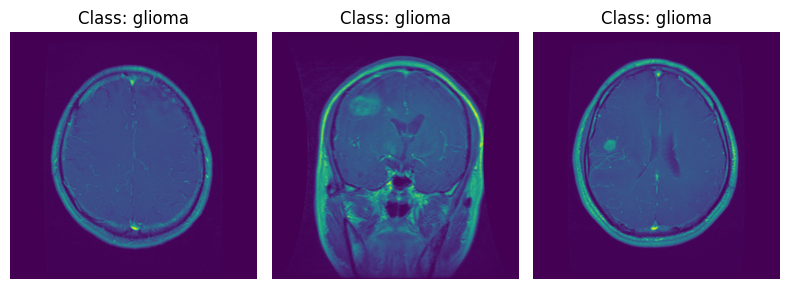

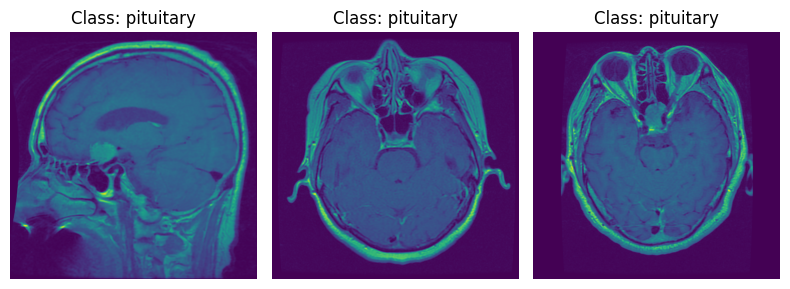

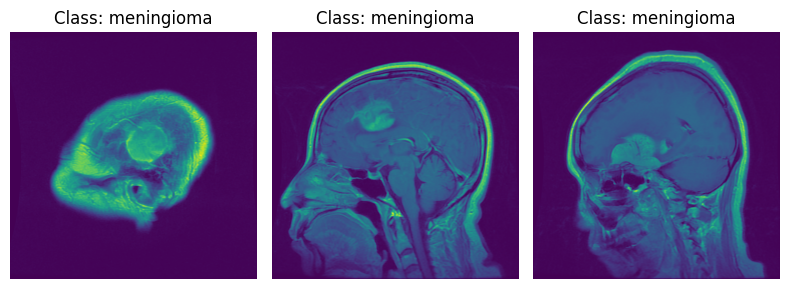

In [38]:
# loop setiap kelas
for class_label in df['label'].unique():
    # mengambil data tertentu
    class_data = df[df['label'] == class_label].head(3)
    fig, axes = plt.subplots(1, 3, figsize=(8, 8))
    
    # loop setiap sampel kelas
    for ax, (_, row) in zip(axes, class_data.iterrows()):
        image_path = row['image']
        
        # menampilkan gambar
        img = Image.open(image_path)
        
        ax.imshow(img)
        ax.set_title(f'Class: {class_label}')
        ax.axis('off')
        img.close()
    
    # mengatur jarak
    plt.tight_layout()
    plt.show()

In [39]:
# menghitung jumlah gambar tiap kelas
class_counts = df['label'].value_counts()
print("Jumlah gambar pada tiap kelas:")
for label, count in class_counts.items():
    print(f"Kelas {label}: {count} gambar")

Jumlah gambar pada tiap kelas:
Kelas glioma: 1426 gambar
Kelas pituitary: 930 gambar
Kelas meningioma: 708 gambar


In [40]:
# memisahkan fitur dan label
x = df['image']
y = df['label']


Why we might want to have separate transformation for train and test (esp if we apply many random augmentation to train set):

> ...When you're testing however, you'll want to use images that aren't altered (except you'll need to normalize the same way). So, for validation/test images, you'll typically just resize and crop. (Ref 1)

In [41]:


transform = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(256),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5], 
                                                           [0.5, 0.5, 0.5])])


In [42]:
transform

Compose(
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    RandomResizedCrop(size=(256, 256), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load the dataset
dataset = datasets.ImageFolder("/kaggle/input/brain-tumor", transform=transform)
display(dataset)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
# using random split
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Define data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)


Dataset ImageFolder
    Number of datapoints: 3064
    Root location: /kaggle/input/brain-tumor
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               RandomResizedCrop(size=(256, 256), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [44]:
print(len(train_dataset))
print(len(val_dataset))

2451
613


In [45]:
type(val_dataset[0][1])

int

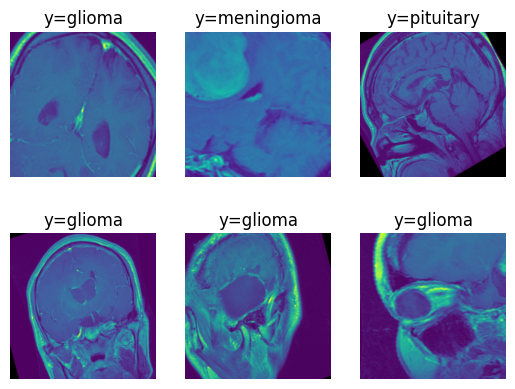

In [46]:
plot_samples(val_dataset, size_even=6, classes={k-1:v for k,v in label_map_dataset.items()})

# Preprocessing

In [47]:
# check random image for patches
H = train_dataset[0][0].shape[1]
W = train_dataset[0][0].shape[2]
patch_size= 16

n_patches=(H/patch_size)* (W/patch_size)
print('n_patches', n_patches)

random_idx = 100
patches=img_to_patch(torch.unsqueeze(train_dataset[random_idx][0],0), patch_size, flatten_channels=False)

print('patch shape', patches.shape )

n_patches 256.0
patch shape torch.Size([1, 256, 3, 16, 16])


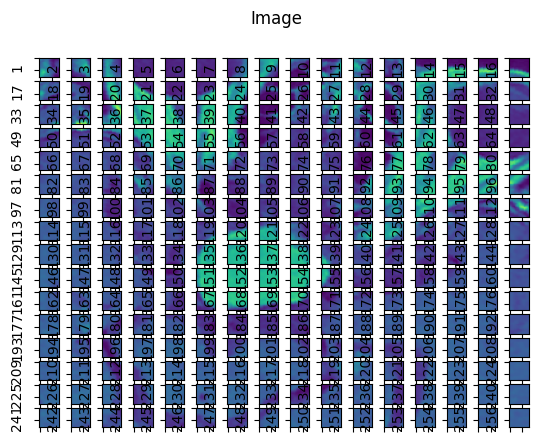

In [48]:
plot_image_patchs(patches)

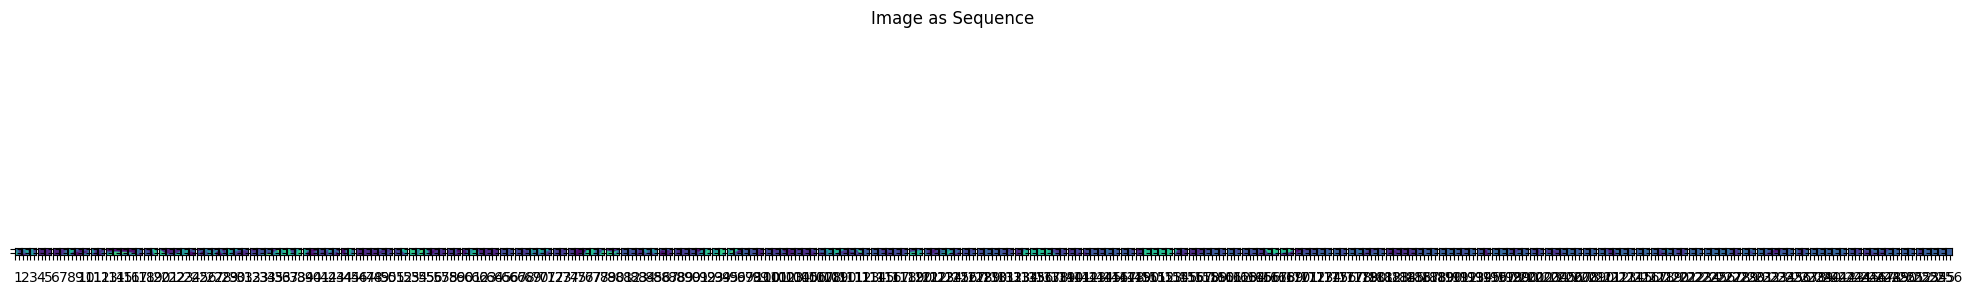

In [49]:
# plot patch sequentially 
plot_image_patchs(patches, seq=True)

In [50]:
# convert image to sequence set
seq_patch = img_to_patch(torch.unsqueeze(train_dataset[random_idx][0],0), patch_size, flatten_channels=True)

# [rgb channel, height, width]
print('original image:', train_dataset[random_idx][0].shape)

# [batch size, n_patches, rgb channel, height per patch, width per patch]
print('image splitted into patches:', patches.shape) 

# [batch size, n_patches, height per patch * width per patch]
print('splitted patches reordered to sequence:',seq_patch.shape) 

original image: torch.Size([3, 256, 256])
image splitted into patches: torch.Size([1, 256, 3, 16, 16])
splitted patches reordered to sequence: torch.Size([1, 256, 768])


In [51]:
seq_patch

tensor([[[-0.7176, -0.5529, -0.3647,  ...,  0.0118, -0.0667, -0.1216],
         [-0.4667, -0.4588, -0.4510,  ..., -0.1137, -0.1216, -0.1216],
         [-0.4431, -0.4431, -0.4431,  ..., -0.0667, -0.1137, -0.1373],
         ...,
         [-0.4902, -0.4980, -0.5216,  ...,  0.1059,  0.0902,  0.0353],
         [-0.4588, -0.4353, -0.4431,  ..., -0.1765, -0.2078, -0.2157],
         [-0.6157, -0.4980, -0.4745,  ..., -0.2706, -0.2706, -0.2784]]])

In [52]:
patches

tensor([[[[[-0.7569, -0.7569, -0.7333,  ..., -0.4431, -0.4431, -0.4353],
           [-0.7176, -0.6784, -0.6157,  ..., -0.4431, -0.4353, -0.4431],
           [-0.6627, -0.6235, -0.5765,  ..., -0.4353, -0.4353, -0.4431],
           ...,
           [-0.7569, -0.7569, -0.6784,  ..., -0.4431, -0.4431, -0.4353],
           [-0.7569, -0.7647, -0.7569,  ..., -0.4431, -0.4431, -0.4431],
           [-0.7333, -0.7490, -0.7333,  ..., -0.4510, -0.4510, -0.4510]],

          [[ 0.1608,  0.2471,  0.1216,  ..., -0.8588, -0.8118, -0.7412],
           [ 0.0353, -0.0667, -0.2235,  ..., -0.8588, -0.8118, -0.6941],
           [-0.0980, -0.1922, -0.2863,  ..., -0.7412, -0.7804, -0.6706],
           ...,
           [ 0.1451,  0.2392,  0.3490,  ..., -0.7176, -0.7412, -0.7412],
           [ 0.2392,  0.2078,  0.2471,  ..., -0.8510, -0.8588, -0.7882],
           [ 0.3098,  0.1529,  0.0902,  ..., -0.8824, -0.9294, -0.8980]],

          [[ 0.0902,  0.0588,  0.0902,  ..., -0.2078, -0.1686, -0.1059],
           [ 0.

# Constructing Vision Transformer model

In [64]:
class AttentionBlock(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
            #source:https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial15/Vision_Transformer.html
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads,
                                          dropout=dropout)
        
        # MultiHeadAttention returns (attn_output, attn_output_weights) # shape attn_output_weights (batch size, target sequence len, source sequnce len)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )


    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        # x below is skipped connection (ie, input + output from layer_norm1)
        x = x + self.attn(inp_x, inp_x, inp_x)[0] # get only attn_output_weights from attn layer
        x = x + self.linear(self.layer_norm_2(x)) # into second layer
        return x
    
class VisionTransformer(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_channels, num_heads, num_layers, num_classes, patch_size, num_patches, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
             #source:https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial15/Vision_Transformer.html
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels*(patch_size**2), embed_dim)
        self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, 64),
            nn.Linear(64, num_classes)
        )
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1,1+num_patches,embed_dim))
        print(num_patches)


    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size, show_prints=False)
        
        B, T, _ = x.shape
        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)

        x = x + self.pos_embedding[:,:T+1]

        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

> The VisionTransformer is utilized for image classification and follows a set of steps to process the input image:
> 
> 1. **Preprocessing**: The img_to_patch function divides the input image into patches.
> 2. **Input Encoding**: The patches pass through an input layer, generating feature vectors.
> 3. **Positional Encoding**: The feature vectors incorporate positional embeddings and a CLS token, capturing spatial information.
> 4. **Transformer Blocks**: Multiple Transformer blocks process the feature vectors and positional embeddings, employing self-attention mechanisms to capture patch dependencies and extract meaningful representations.
> 5. **Classification Prediction**: The output from the Transformer blocks enters an MLP head, responsible for the final classification prediction.
> 
> The VisionTransformer class encapsulates the necessary layers and parameters to construct and execute this model.
> 
> Please note that the code may reference additional functions and classes, such as AttentionBlock and img_to_patch, which handle specific operations within the model.

(from model + training ref 1)

> To create a VisionTransformer object, we utilize values similar to "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale."
> Here's a breakdown of what each parameter represents:
> 
> - <code>embed_dim</code>: This parameter determines the dimensionality of the embedded feature representation of each patch in the image. In this case, it is set to 256.
> - <code>hidden_dim</code>: It represents the dimensionality of the hidden layer in the model. The hidden layer contains intermediate representations and computations. Here, it is set to 512.
> - <code>num_heads</code>: This parameter specifies the number of attention heads in the self-attention mechanism. Each head attends to different parts of the input, allowing the model to capture different types of relationships. In this case, there are 8 attention heads.
> - <code>num_layers</code>: It indicates the number of transformer layers in the VisionTransformer model. Each layer processes the input sequentially, refining the representations. Here, there are 6 transformer layers.
> - <code>patch_size</code>: It represents the size of each patch extracted from the input image. In this case, patches are square and have a size of 4x4 pixels.
> - <code>num_channels</code>: This parameter denotes the number of channels in the input image. For grayscale images, like in this case, the number of channels is 1.
> - <code>num_patches</code>: It indicates the total number of patches that make up the image. This value is calculated based on the image size and patch size. Here, there are 64 patches.
> - <code>num_classes</code>: This parameter specifies the number of classes in the classification task. In this case, the model is designed for a classification problem with 10 classes.
> - <code>dropout</code>: It represents the dropout rate, which is a regularization technique used to prevent overfitting. Dropout randomly sets a fraction of the input units to 0 during training. Here, the dropout rate is set to 0.2, meaning 20% of the input units will be zeroed out during training.
> 

In [65]:

H = train_dataset[0][0].shape[1]
W = train_dataset[0][0].shape[2]

print(H,W)

256 256


In [66]:
embed_dim= 256
hidden_dim=512
num_heads= 8
assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
num_layers=6
patch_size=16
num_channels=train_dataset[0][0].shape[0]
num_patches=int((H/patch_size)* (W/patch_size))
num_classes=3
dropout=0.2
model=VisionTransformer( embed_dim= embed_dim, hidden_dim=hidden_dim, num_channels=num_channels, num_heads=num_heads, num_layers=num_layers, num_classes=num_classes, patch_size=patch_size, num_patches=num_patches, dropout=dropout)

256


In [67]:
model # (input layer, 2 attention blocks (num_layers), classification layer)

VisionTransformer(
  (input_layer): Linear(in_features=768, out_features=256, bias=True)
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (linear): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=512, out_features=256, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
    (1): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): Laye

In [68]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
device

device(type='cpu')

In [69]:
lr=3e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = ExponentialLR(optimizer, gamma=0.9)

In [70]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.0003
    lr: 0.0003
    maximize: False
    weight_decay: 0.01
)

In [71]:
scheduler

In [72]:
def accuracy(true,pred):
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    return float(100 * acc.sum() / len(acc))


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()

    for batch_num, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass to compute prediction
        pred = model(X)
        # Compute prediction error using loss function
        loss = loss_fn(pred, y)

        # Backward pass
        optimizer.zero_grad() # zero any previous gradient calculations
        loss.backward() # calculate gradient
        optimizer.step() # update model parameters
        
        if batch_num > 0 and batch_num % 10 == 0:
            loss, current = loss.item(), batch_num * len(X)
            train_acc = accuracy(y, pred)
            print(f"loss: {loss:>7f}  Accuracy: {train_acc:>0.1f}%    [{current:>5d}/{size:>5d}]")
            

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Note:
1. increasing pixel sharpness reduce loss.
```
size (28,28):
loss ≈ 2.
acc ≈ 40%
size (256,256):
loss ≈ 1.
acc ≈ 59%
```
2. adding more encoder layers make training unstable? -- Accuracy could wildly oscillate between 0% and 80%. Overfitting?
```
num_layers = 6
loss ≈ 1.
acc ≈ 59%
num_layers = 8
loss = 0.8
acc = 56%
```
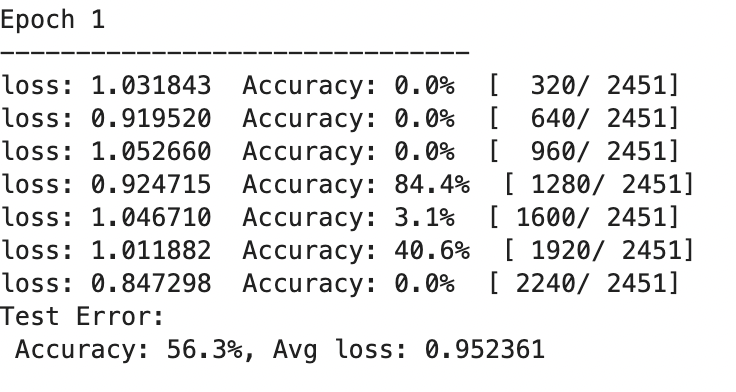

Some reading: https://stats.stackexchange.com/questions/256551/why-does-the-accuracy-not-change-when-applying-different-alpha-values-in-l2-reg/256554#256554

3. adding more fully connected layer.
```
original:
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
updated:
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, 64),
            nn.Linear(64, num_classes)
        )
```
```
original:
loss ≈ 1.
acc ≈ 59%
updated:
loss ≈ 0.8
acc ≈ 60%
```
4. many more fine tuning we can do to improve the model! eg model params (num_heads, patch_size, add or remove layers, Linear layer nodes, Linear layer activation...), training params (learning rates, initialized weights...)

In [63]:
# Experiment 2: adding more encoder layers
# # Let's run training
# epochs = 5
# for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     train(train_loader, model, criterion, optimizer)
#     test(val_loader, model, criterion)
# print("Done!")

Epoch 1
-------------------------------
loss: 1.031843  Accuracy: 0.0%  [  320/ 2451]
loss: 0.919520  Accuracy: 0.0%  [  640/ 2451]
loss: 1.052660  Accuracy: 0.0%  [  960/ 2451]
loss: 0.924715  Accuracy: 84.4%  [ 1280/ 2451]
loss: 1.046710  Accuracy: 3.1%  [ 1600/ 2451]
loss: 1.011882  Accuracy: 40.6%  [ 1920/ 2451]
loss: 0.847298  Accuracy: 0.0%  [ 2240/ 2451]
Test Error: 
 Accuracy: 56.3%, Avg loss: 0.952361 

Epoch 2
-------------------------------
loss: 1.121084  Accuracy: 0.0%  [  320/ 2451]
loss: 1.045061  Accuracy: 0.0%  [  640/ 2451]
loss: 1.023741  Accuracy: 0.0%  [  960/ 2451]
loss: 1.000099  Accuracy: 21.9%  [ 1280/ 2451]
loss: 0.853847  Accuracy: 6.2%  [ 1600/ 2451]
loss: 0.875480  Accuracy: 65.6%  [ 1920/ 2451]
loss: 0.991206  Accuracy: 21.9%  [ 2240/ 2451]
Test Error: 
 Accuracy: 57.4%, Avg loss: 0.837861 

Epoch 3
-------------------------------
loss: 1.124985  Accuracy: 15.6%  [  320/ 2451]
loss: 0.763605  Accuracy: 46.9%  [  640/ 2451]
loss: 0.915431  Accuracy: 0.0%  [

In [73]:
# Experiment 3: adding more fully connected layers
# Let's run training
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, criterion, optimizer)
    test(val_loader, model, criterion)
print("Done!")

Epoch 1
-------------------------------
loss: 1.071563  Accuracy: 84.4%    [  320/ 2451]
loss: 1.197772  Accuracy: 0.0%    [  640/ 2451]
loss: 1.085130  Accuracy: 0.0%    [  960/ 2451]
loss: 0.854448  Accuracy: 0.0%    [ 1280/ 2451]
loss: 1.027262  Accuracy: 6.2%    [ 1600/ 2451]
loss: 0.863581  Accuracy: 71.9%    [ 1920/ 2451]
loss: 0.832115  Accuracy: 78.1%    [ 2240/ 2451]
Test Error: 
 Accuracy: 58.1%, Avg loss: 0.892166 

Epoch 2
-------------------------------
loss: 0.964813  Accuracy: 37.5%    [  320/ 2451]
loss: 1.221032  Accuracy: 0.0%    [  640/ 2451]
loss: 0.915906  Accuracy: 0.0%    [  960/ 2451]
loss: 1.097029  Accuracy: 0.0%    [ 1280/ 2451]
loss: 0.886687  Accuracy: 25.0%    [ 1600/ 2451]
loss: 1.024800  Accuracy: 50.0%    [ 1920/ 2451]
loss: 0.727806  Accuracy: 3.1%    [ 2240/ 2451]
Test Error: 
 Accuracy: 61.5%, Avg loss: 0.845178 

Epoch 3
-------------------------------
loss: 1.045070  Accuracy: 0.0%    [  320/ 2451]
loss: 1.003344  Accuracy: 65.6%    [  640/ 2451]
l

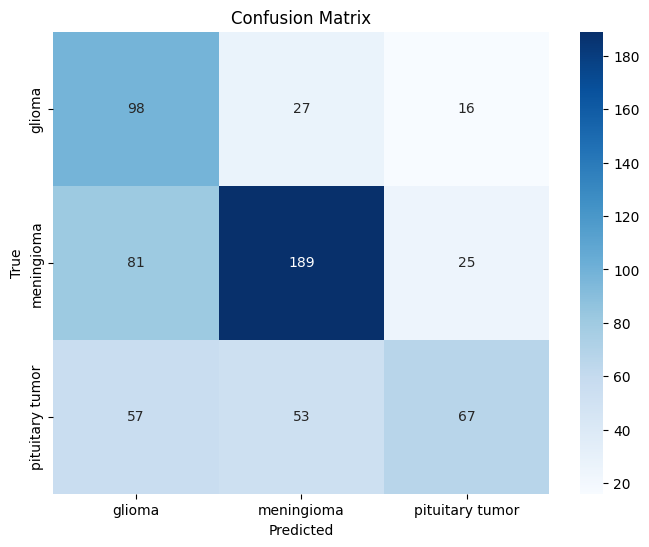

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Evaluation loop
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

# Create confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Define class labels
class_labels = ['glioma', 'meningioma', 'pituitary tumor']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# printing shapes

In [ ]:
# printing shapes for each layer

# def fw_hook(module, input, output):
#     if isinstance(output, tuple):
#         print(f"Shape of output to {module} is {output[1].shape}.")
#     else:
#         print(f"Shape of output to {module} is {output.shape}.")
        

# for name, layer in model.named_modules():
#     layer.register_forward_hook(fw_hook)

In [34]:
# useful_stuff = {'training_loss': [], 'validation_accuracy': []}
# correct_old=0

# for epoch in tqdm(range(2)):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(train_loader):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data[0].to(device), data[1].to(device)
#         print('inputs', inputs.shape)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         model.train()
#         outputs = model(inputs)

#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()

#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
#             running_loss = 0.0
#     scheduler.step()
#     useful_stuff['training_loss'].append(running_loss)
#     correct = 0
#     model.eval()
    
#     for inputs, labels in test_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         z = model(inputs)
#         _, yhat = torch.max(z, 1)
#         correct += (yhat == labels).sum().item()
#         if correct>correct_old:
#             correct_old=correct
    
#     useful_stuff['validation_accuracy'].append(correct_old/len(test_set))
# print('Finished Training')


  0%|          | 0/2 [00:00<?, ?it/s]

inputs torch.Size([32, 3, 28, 28])
img_to_patch() | reshaped torch.Size([32, 3, 7, 4, 7, 4])
img_to_patch() | permute torch.Size([32, 7, 7, 3, 4, 4])
img_to_patch() | flatten torch.Size([32, 49, 3, 4, 4])
img_to_patch() | flatten_channels torch.Size([32, 49, 48])
after img_to_patch torch.Size([32, 49, 48])
Shape of output to Linear(in_features=48, out_features=256, bias=True) is torch.Size([32, 49, 256]).
Shape of output to Dropout(p=0.2, inplace=False) is torch.Size([32, 50, 256]).
Shape of output to LayerNorm((256,), eps=1e-05, elementwise_affine=True) is torch.Size([50, 32, 256]).
Shape of output to MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
) is torch.Size([32, 50, 50]).
Shape of output to LayerNorm((256,), eps=1e-05, elementwise_affine=True) is torch.Size([50, 32, 256]).
Shape of output to Linear(in_features=256, out_features=512, bias=True) is torch.Size([50, 32, 512]).
Shape of output to GELU(approximate='none'

  0%|          | 0/2 [00:10<?, ?it/s]


KeyboardInterrupt: 